## test Feature_Branch

In [ ]:
from modules.FeatureBranch import Feature_Branch

reshape_channel = 32
reshape_depth = 16
num_resblocks = 6
linear_channels = [3072, 2048, 1024, 768]
upsample_channels = [3072, 2048, 1024, 512]
downsample_channels = [512, 512, 512, 768]
arcface_path = '/home/wenchi/zxy/HSD/utils/arcface_pytorch/checkpoints/resnet18_110_onecard.pth' 
resNext_path = '/home/wenchi/zxy/HSD/utils/ResNeXt/resnext_50_32x4d_modified.pth'

test_branch = Feature_Branch()


In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import torch
test_branch.cuda()

data_for_id = torch.randn(4, 1024).cuda()
data_for_global = torch.randn(4, 3, 224, 224).cuda()

In [ ]:
out = test_branch(data_for_id, data_for_global)
print(out.shape)

## test Condition_Branch

In [ ]:
from modules.ConditionBranch import Condition_Branch

test_branch = Condition_Branch()

In [ ]:
import random
import torch
def get_code_dict(code_dict, batch_size = 4, pose_threshold = 0.02):
    # this method get original a clip code_dict as input
    # return the indexs selected randomly and the corresponding combined code_dict

    tforms = code_dict['tforms']
    shape_code = code_dict['shape']
    tex_code = code_dict['tex']
    exp_code = code_dict['exp']
    pose_code = code_dict['pose']
    cam_code = code_dict['cam']
    light_code = code_dict['light']

    tforms_new = torch.zeros(batch_size, tforms.shape[1], tforms.shape[2])
    shape_code_new = torch.zeros(batch_size, shape_code.shape[1])
    tex_code_new = torch.zeros(batch_size, tex_code.shape[1])
    exp_code_new = torch.zeros(batch_size, exp_code.shape[1])
    pose_code_new = torch.zeros(batch_size, pose_code.shape[1])
    cam_code_new = torch.zeros(batch_size, cam_code.shape[1])
    light_code_new = torch.zeros(batch_size, light_code.shape[1], light_code.shape[2])

    total_num = pose_code.shape[0]
    count = 0
    index = []

    while True:
        a = random.randint(0, total_num-1)       # a for source
        b = random.randint(0, total_num-1)       # b for target
        if abs(torch.mean(pose_code[a] - pose_code[b])) >= pose_threshold:

            # get combined code
            tforms_new[count, :] = tforms[b]
            shape_code_new[count, :] = shape_code[a]
            tex_code_new[count, :] = tex_code[a]
            exp_code_new[count, :] = exp_code[b]
            pose_code_new[count, :] = pose_code[b]
            cam_code_new[count, :] = cam_code[b]
            light_code_new[count, :] = light_code[b]

            # get index
            index.append((a, b))

            count +=1

            if count == batch_size:
                new_code_dict = {
                    'tforms':tforms_new.cuda(),
                    'shape':shape_code_new.cuda(),
                    'tex':tex_code_new.cuda(),
                    'exp':exp_code_new.cuda(),
                    'pose':pose_code_new.cuda(),
                    'cam':cam_code_new.cuda(),
                    'light':light_code_new.cuda()
                }
                return new_code_dict, index
        else:
            continue

In [ ]:
import pickle
import os.path as osp
import numpy as np
from PIL import Image
import cv2
import torch

clip_path = '/data0/wc_data/VFHQ/train/Clip+xz26EN_LRa8+P0+C0+F4517-4639'

with open(osp.join(clip_path, '3DMM_condition.pkl'), 'rb') as f:
    data = pickle.load(f)

codedict, index = get_code_dict(data)

source_image_list = []
target_image_list = []
mask_image_list = []
bg_image_list = []


# get images
for i in range(len(index)):
    source_image_path = osp.join(clip_path, '{}.png'.format(str(index[i][0]).zfill(8)))
    target_image_path = osp.join(clip_path, '{}.png'.format(str(index[i][1]).zfill(8)))
    mask_image_path = osp.join(clip_path, 'mask_{}.jpg'.format(str(index[i][1]).zfill(8)))
    source_image_list.append(np.asarray(Image.open(source_image_path).convert("RGB")))
    target_image_list.append(np.asarray(Image.open(target_image_path).convert("RGB")))
    mask_image_list.append(np.asarray(Image.open(mask_image_path)))

# get masked images (background)
for i in range(len(index)):
    mask = mask_image_list[i]
    mask = cv2.GaussianBlur(mask, (11, 11), 11)
    mask = np.where( (mask <= 0), 0, 255).astype('uint8')
    bg_image_list.append(cv2.bitwise_and(target_image_list[i], target_image_list[i], mask = 255 - mask))

source_images = np.asarray(source_image_list)
target_images = np.asarray(target_image_list) # np.array, uint8, 
mask_images = np.asarray(mask_image_list)
bg_images = np.asarray(bg_image_list)

bg_images = torch.from_numpy((bg_images / 255.0).transpose(0, 3, 1, 2))
bg_images = bg_images.cuda()

# for key in codedict:
#     print('key: {} has shape : {} '.format(key, str(codedict[key].shape)))

out = test_branch(codedict, bg_images)

Image_source = source_image_list[0]
Image_target = target_image_list[0]
Image_mask = np.tile(mask_image_list[0] , (3, 1, 1)).transpose(1, 2, 0)
Image_bg = bg_image_list[0]
Image_out = (out[0].cpu().numpy().transpose(1, 2, 0) * 255).astype(np.uint8)

Image_concat = np.concatenate((Image_source, Image_target, Image_mask, Image_bg, Image_out), axis= 1)
a = Image.fromarray(Image_concat)
a.save('/home/wenchi/zxy/HSD/test_condition.jpg')



### test pose distance and test for pose threshold

In [ ]:
import pickle
import matplotlib.pyplot as plt
import random

with open('/data0/wc_data/VFHQ/train/Clip+_aZphIp0KQE+P0+C1+F2675-2891/3DMM_condition.pkl', 'rb') as f:
    data = pickle.load(f)

pose_code = data['pose']

total_num = pose_code.shape[0]
 
plt.figure(figsize=(10, 10))

row_list = []
col_list = []
# for i in range(1, 100):
#     sum = 0
#     for j in range(total_num - i):
#         pose_1 = pose_code[j]
#         pose_2 = pose_code[j+i]
#         sum += torch.mean(pose_1 - pose_2)
#     sum /= (total_num - i)
#     print('间隔{}帧的图像pose 平均差值为{}'.format(i, sum))
#     i_list.append(i)
#     sum_list.append(sum)
result = [0, 0, 0, 0, 0, 0, 0]
for i in range(100000):
    a = random.randint(0, total_num-1)
    b = random.randint(0, total_num-1)

    pose_1 = pose_code[a]
    pose_2 = pose_code[b]
    temp = torch.mean(pose_1 - pose_2)
    index = min(abs(int(temp / 0.01)), 6)
    result[index] +=1


plt.scatter(['0~0.01', '0.01~0.02', '0.02~0.03', '0.03~0.04', '0.04~0.05', '0.05~0.06', '>=0.06'], result)
plt.show()

In [ ]:
import torch
a = torch.randn(6)
b = torch.randn(6)
print(a-b)
print(torch.mean(a - b))

## test combine ckpt

In [8]:
import sys
import os

os.system('export PYTHONPATH=/home/wenchi/zxy/HSD/ControlNet/')
sys.path.append('/home/wenchi/zxy/HSD/ControlNet/')
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [9]:
# mapper_path = "/data1/wc_log/zxy/ckpt/v3.4-epoch=492-global_step=820619.0.ckpt"
pretrain_path = '/data1/wc_log/zxy/ckpt/v3.5.2-epoch=103-global_step=8423.0.ckpt'
# b_path = '/data1/wc_log/zxy/ckpt/v3.6-epoch=99-global_step=64599.0.ckpt'


import torch
from share import *
from cldm.model import create_model


pretrained_weights = torch.load(pretrain_path, map_location='cuda:0')
# mapper_weights = torch.load(mapper_path)['state_dict']

logging improved.
Enabled sliced_attention.


In [11]:
pretrained_weights = pretrained_weights['state_dict']

In [12]:
for key in pretrained_weights:
    print(f'{key}')

betas
alphas_cumprod
alphas_cumprod_prev
sqrt_alphas_cumprod
sqrt_one_minus_alphas_cumprod
log_one_minus_alphas_cumprod
sqrt_recip_alphas_cumprod
sqrt_recipm1_alphas_cumprod
posterior_variance
posterior_log_variance_clipped
posterior_mean_coef1
posterior_mean_coef2
logvar
model.diffusion_model.time_embed.0.weight
model.diffusion_model.time_embed.0.bias
model.diffusion_model.time_embed.2.weight
model.diffusion_model.time_embed.2.bias
model.diffusion_model.input_blocks.0.0.weight
model.diffusion_model.input_blocks.0.0.bias
model.diffusion_model.input_blocks.1.0.in_layers.0.weight
model.diffusion_model.input_blocks.1.0.in_layers.0.bias
model.diffusion_model.input_blocks.1.0.in_layers.2.weight
model.diffusion_model.input_blocks.1.0.in_layers.2.bias
model.diffusion_model.input_blocks.1.0.emb_layers.1.weight
model.diffusion_model.input_blocks.1.0.emb_layers.1.bias
model.diffusion_model.input_blocks.1.0.out_layers.0.weight
model.diffusion_model.input_blocks.1.0.out_layers.0.bias
model.diffusi

In [ ]:
# create model

import torch
from cldm.model import create_model
model = create_model(config_path='/home/wenchi/zxy/HSD/ControlNet/models/cldm_pve_v3.6.yaml')

In [14]:
scratch_dict = model.state_dict()
for key in scratch_dict:
    print(key)

betas
alphas_cumprod
alphas_cumprod_prev
sqrt_alphas_cumprod
sqrt_one_minus_alphas_cumprod
log_one_minus_alphas_cumprod
sqrt_recip_alphas_cumprod
sqrt_recipm1_alphas_cumprod
posterior_variance
posterior_log_variance_clipped
posterior_mean_coef1
posterior_mean_coef2
logvar
model.diffusion_model.time_embed.0.weight
model.diffusion_model.time_embed.0.bias
model.diffusion_model.time_embed.2.weight
model.diffusion_model.time_embed.2.bias
model.diffusion_model.input_blocks.0.0.weight
model.diffusion_model.input_blocks.0.0.bias
model.diffusion_model.input_blocks.1.0.in_layers.0.weight
model.diffusion_model.input_blocks.1.0.in_layers.0.bias
model.diffusion_model.input_blocks.1.0.in_layers.2.weight
model.diffusion_model.input_blocks.1.0.in_layers.2.bias
model.diffusion_model.input_blocks.1.0.emb_layers.1.weight
model.diffusion_model.input_blocks.1.0.emb_layers.1.bias
model.diffusion_model.input_blocks.1.0.out_layers.0.weight
model.diffusion_model.input_blocks.1.0.out_layers.0.bias
model.diffusi

In [16]:
new_weights = {}
for key in scratch_dict:
    if 'cond_stage_model.id_residual_block.' in key or 'control_model.' in key:
        new_weights[key] = scratch_dict[key]
        print(f'{key} train from scratch')
    else:
        new_weights[key] = pretrained_weights[key]


cond_stage_model.id_residual_block.id_residual_ST.norm.weight train from scratch
cond_stage_model.id_residual_block.id_residual_ST.norm.bias train from scratch
cond_stage_model.id_residual_block.id_residual_ST.proj_in.weight train from scratch
cond_stage_model.id_residual_block.id_residual_ST.proj_in.bias train from scratch
cond_stage_model.id_residual_block.id_residual_ST.transformer_blocks.0.attn1.to_q.weight train from scratch
cond_stage_model.id_residual_block.id_residual_ST.transformer_blocks.0.attn1.to_k.weight train from scratch
cond_stage_model.id_residual_block.id_residual_ST.transformer_blocks.0.attn1.to_v.weight train from scratch
cond_stage_model.id_residual_block.id_residual_ST.transformer_blocks.0.attn1.to_out.0.weight train from scratch
cond_stage_model.id_residual_block.id_residual_ST.transformer_blocks.0.attn1.to_out.0.bias train from scratch
cond_stage_model.id_residual_block.id_residual_ST.transformer_blocks.0.ff.net.0.proj.weight train from scratch
cond_stage_model.

In [17]:
torch.save(new_weights, '/data1/wc_log/zxy/ckpt/v3.6-begin.ckpt')

In [ ]:
a = pretrained_weights['control_model.input_blocks.8.0.out_layers.3.weight'].cuda()
b = contrast_weights['control_model.input_blocks.8.0.out_layers.3.weight']
distance = a - b
print(distance.data)
print(distance.min())
print(distance.max())

In [ ]:
for key in pretrained_weights:
    print(key)

In [12]:
scratch_dict = model.state_dict()

target_dict = pretrained_weights
mapper_dict = mapper_weights

# for key in target_dict:
#     if key in scratch_dict:
#         scratch_dict[key] = target_dict[key]
#     else:
#         print('key {} not in scratch_dict'.format(key))


for key in pretrained_weights:
    if 'cond_stage_model.mapper' in key:
        pretrained_weights[key] = mapper_dict[key]
        print('key {} in mapper_dict'.format(key))

# 保存 scratch_dict
torch.save(pretrained_weights, '/data1/wc_log/zxy/ckpt/v3.5.2-begin.ckpt')

key cond_stage_model.mapper.resblocks.0.attn.c_qkv.weight in mapper_dict
key cond_stage_model.mapper.resblocks.0.attn.c_qkv.bias in mapper_dict
key cond_stage_model.mapper.resblocks.0.attn.c_proj.weight in mapper_dict
key cond_stage_model.mapper.resblocks.0.attn.c_proj.bias in mapper_dict
key cond_stage_model.mapper.resblocks.0.ln_1.weight in mapper_dict
key cond_stage_model.mapper.resblocks.0.ln_1.bias in mapper_dict
key cond_stage_model.mapper.resblocks.0.mlp.c_fc.weight in mapper_dict
key cond_stage_model.mapper.resblocks.0.mlp.c_fc.bias in mapper_dict
key cond_stage_model.mapper.resblocks.0.mlp.c_proj.weight in mapper_dict
key cond_stage_model.mapper.resblocks.0.mlp.c_proj.bias in mapper_dict
key cond_stage_model.mapper.resblocks.0.ln_2.weight in mapper_dict
key cond_stage_model.mapper.resblocks.0.ln_2.bias in mapper_dict
key cond_stage_model.mapper.resblocks.1.attn.c_qkv.weight in mapper_dict
key cond_stage_model.mapper.resblocks.1.attn.c_qkv.bias in mapper_dict
key cond_stage_mod

In [ ]:
pretrained_weights_keys = list(pretrained_weights.keys())
for key in pretrained_weights_keys:
    print(key)
    # prefix = key.split('.', 1)[0]
    # if prefix == 'cond_stage_model':
    #     del pretrained_weights[key]

# for key in condition_weight:
#     add_key = 'cond_stage_model.' + key
#     pretrained_weights[add_key] = condition_weight[key].clone()

In [ ]:
model = create_model(config_path='/home/wenchi/zxy/HSD/ControlNet/models/cldm_pve_v2.yaml')
# for name, param in model.named_parameters():
#     if param.requires_grad:
#         print(name)
# print(model.state_dict().keys())

In [ ]:
scratch_dict = model.state_dict()

target_dict = {}
for k in scratch_dict.keys():
    is_control, name = get_node_name(k, 'control_')
    if is_control:
        copy_k = 'model.diffusion_' + name
    else:
        copy_k = k
    if copy_k in pretrained_weights:
        target_dict[k] = pretrained_weights[copy_k].clone()
    else:
        target_dict[k] = scratch_dict[k].clone()
        print(f'These weights are newly added: {k}')

model.load_state_dict(target_dict, strict=True)
torch.save(model.state_dict(), output_path)
print('Done.')

## test CLIP

In [ ]:
from transformers import  CLIPVisionModel
from ControlNet.ldm.modules.encoders.xf import LayerNorm, Transformer

version="openai/clip-vit-large-patch14"
transformer = CLIPVisionModel.from_pretrained(version)

In [ ]:
import torch
image = torch.rand(2, 3, 224, 224)

mapper = Transformer(
                n_ctx = 257,
                width = 1024,
                layers = 5,
                heads = 8,
            )
final_ln = LayerNorm(1024)

In [ ]:
with torch.no_grad():
    outputs = transformer(pixel_values=image)
    print('last_hidden_state : ', outputs.last_hidden_state.shape)
    print('pooler_output : ', outputs.pooler_output.shape)

    z = outputs.last_hidden_state
    print('z : ', z.shape)
    z = mapper(z)
    print('z mapper: ', z.shape)
    z = final_ln(z)
    print('z final: ', z.shape)

## test mask process

In [ ]:
%matplotlib inline
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

def mask_find_bbox(mask):
    mask_col = np.sum(mask, axis= 0)
    mask_row = np.sum(mask, axis= 1)

    left = np.where(mask_col >= 255)[0][0]
    right = np.where(mask_col >= 255)[0][-1]
    up = np.where(mask_row >= 255)[0][0]
    down = np.where(mask_row >= 255)[0][-1]

    bbox = [left, up, right, down]
    return bbox

def smooth_mask(mask_image):
    mask_image = cv2.GaussianBlur(mask_image, (11, 11), 11)
    mask_image = np.where( (mask_image <= 0), 0, 255).astype('uint8')
    return mask_image

def get_align_image(bbox, img, reshape_size = 224):
    h, w, _ = img.shape
    x1, y1, x2, y2 = bbox[0], bbox[1], bbox[2], bbox[3]

    center_point = [int((x1 + x2) / 2), int((y1 + y2) / 2)] ## recalculate the center point
    expand_size = int((y2 - y1) * 0.5) # expand_size -- half of the total crop size
    crop_size = expand_size * 2

    new_x1 = center_point[0] - expand_size
    new_x2 = center_point[0] + expand_size
    new_y1 = center_point[1] - expand_size
    new_y2 = center_point[1] + expand_size

    (crop_left, origin_left) = (0, new_x1) if new_x1 >= 0 else (-new_x1, 0)
    (crop_right, origin_right) = (crop_size, new_x2) if new_x2 <= w else (w-new_x1, w)
    (crop_top, origin_top) = (0, new_y1) if new_y1 >= 0 else (-new_y1, 0)
    (crop_bottom, origin_bottom) = (crop_size, new_y2) if new_y2 <= h else (h-new_y1, h)

    aligned_img = np.zeros((crop_size, crop_size, 3), dtype=np.uint8)
    aligned_img[crop_top:crop_bottom, crop_left:crop_right] = img[origin_top:origin_bottom, origin_left:origin_right]
    aligned_img = Image.fromarray(aligned_img)
    aligned_img = aligned_img.resize((reshape_size, reshape_size))
    aligned_img = np.asarray(aligned_img)
    return aligned_img

source_mask_path = '/data0/wc_data/VFHQ/train/Clip+Y8k-XLGO2SY+P0+C0+F950-1055/mask_00000067.jpg'
source_mask = np.asarray(Image.open(source_mask_path)) # (H, W)
source_mask = smooth_mask(source_mask)

plt.imshow(source_mask, cmap='bone')

In [ ]:
source_image_path = '/data0/wc_data/VFHQ/train/Clip+Y8k-XLGO2SY+P0+C0+F950-1055/00000067.png'
source_image = np.asarray(Image.open(source_image_path).convert("RGB"))
plt.imshow(source_image)

In [ ]:
source_image = cv2.bitwise_and(source_image, source_image, mask = source_mask)
plt.imshow(source_image)

In [ ]:
bbox = mask_find_bbox(source_mask)
source_image = get_align_image(bbox=bbox, img=source_image)
plt.imshow(source_image)

## test random mask

In [ ]:
%matplotlib inline
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

def smooth_mask(mask_image, ksize=(11, 11), sigmaX= 11, sigmaY= 11):
    # need to be applied in data preprocess, and drop this
    # GaussianBlur again to reduce mask edge serrate
    mask_image = cv2.GaussianBlur(mask_image, ksize, sigmaX=sigmaX, sigmaY = sigmaY)
    mask_image = np.where( (mask_image <= 0), 0, 255).astype('uint8')
    return mask_image

def mask_find_bbox(mask):
    mask_col = np.sum(mask, axis= 0)
    mask_row = np.sum(mask, axis= 1)

    left = np.where(mask_col >= 255)[0][0]
    right = np.where(mask_col >= 255)[0][-1]
    up = np.where(mask_row >= 255)[0][0]
    down = np.where(mask_row >= 255)[0][-1]

    bbox = [left, up, right, down]
    return bbox

In [ ]:
target_image_path = '/data0/wc_data/VFHQ/test/Clip+D4BdpI6h1As+P1+C0+F809-925/00000021.png'
target_mask_path = '/data0/wc_data/VFHQ/test/Clip+D4BdpI6h1As+P1+C0+F809-925/mask_00000021.jpg'

# target_image_path = '/data0/wc_data/VFHQ/test/Clip+okx7B5ggBvo+P0+C0+F3046-3157/00000053.png'
# target_mask_path = '/data0/wc_data/VFHQ/test/Clip+okx7B5ggBvo+P0+C0+F3046-3157/mask_00000053.jpg'

target_image = np.asarray(Image.open(target_image_path).convert("RGB"))
target_mask_image = np.asarray(Image.open(target_mask_path))

plt.imshow(target_mask_image, cmap= 'bone')

In [ ]:
# target_mask_image_big = smooth_mask(target_mask_image,ksize=(55, 55), sigmaX= 33, sigmaY= 33)
import random
random_int = random.sample(range(-15, 20), 4)
print(random_int)
# target_mask_image_big = smooth_mask(target_mask_image,ksize=(33, 33), sigmaX= 33, sigmaY= 33)
# target_mask_image_big = smooth_mask(target_mask_image,ksize=(11, 11), sigmaX= 33, sigmaY= 33)
target_mask_image_big = smooth_mask(target_mask_image,ksize=(33 + random_int[0]*2, 33 + random_int[1]*2), sigmaX= 33 + random_int[2]*2, sigmaY= 43 + random_int[3]*2)
plt.imshow(target_mask_image_big, cmap= 'bone')

In [ ]:
enlarged_box = mask_find_bbox(target_mask_image_big)
random_point_nums = 50

x_coords = np.random.randint(enlarged_box[0], enlarged_box[2], (random_point_nums, 1))
y_coords = np.random.randint(enlarged_box[1], enlarged_box[3], (random_point_nums, 1))
points = np.concatenate([x_coords, y_coords], axis= 1)

pixel_values = target_mask_image_big[x_coords, y_coords]
mask = np.concatenate([pixel_values == 0, pixel_values == 0], axis= 1)
black_points = points[mask]
black_points = np.reshape(black_points, (-1, 2))

hull = cv2.convexHull(black_points)


# blackbg = np.zeros((512, 512), dtype=np.uint8)
# for hull_one in hull:
#     blackbg = cv2.circle(blackbg, hull_one[0], radius=3, color=(255, 255, 255), thickness=-1)
# plt.imshow(blackbg, cmap= 'bone')

# # 将这些点作为轮廓生成一个面，面里面填充纯白色
cv2.fillPoly(target_mask_image_big, [black_points], 255)

# # 显示图像
plt.imshow(target_mask_image_big, cmap= 'bone')

In [ ]:
target_mask_image_distance = target_mask_image_big - target_mask_image
plt.imshow(target_mask_image_distance, cmap= 'bone')

In [ ]:
target_image_masked = cv2.bitwise_and(target_image, target_image, mask = target_mask_image_big) # get masked
plt.imshow(target_image_masked)

In [ ]:
target_image_background = cv2.bitwise_and(target_image, target_image, mask = 255 - target_mask_image_big) # get masked
plt.imshow(target_image_background)

## test id loss

output_size == DEFAULT_CROP_SIZE [112 112]: return default reference points
output_size == DEFAULT_CROP_SIZE [112 112]: return default reference points


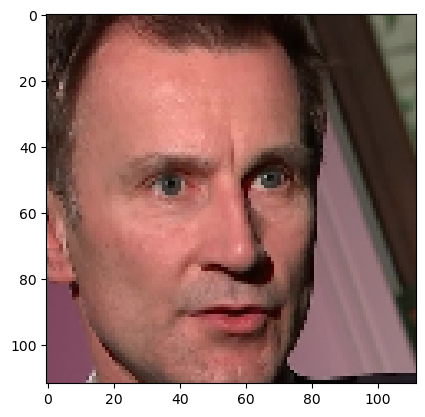

In [12]:
%matplotlib inline
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import cv2
import torch

from utils.Face_Alignment.align_faces import warp_and_crop_face_tensor, get_reference_facial_points
from utils.Face_Alignment.retinaface.detector import RetinafaceDetector

image_a_1 = '/data1/wc_log/zxy/VFHQ/test/Clip+D4BdpI6h1As+P1+C0+F809-925/00000034.png'
image_a_2 = '/data1/wc_log/zxy/VFHQ/test/Clip+D4BdpI6h1As+P1+C0+F809-925/00000025.png'

image_b_1 = '/data1/wc_log/zxy/VFHQ/test/Clip+okx7B5ggBvo+P0+C0+F3046-3157/00000053.png'
image_b_2 = '/data1/wc_log/zxy/VFHQ/test/Clip+okx7B5ggBvo+P0+C0+F3046-3157/00000015.png'

detector = RetinafaceDetector(type='cuda')


def crop_align_image(img: torch.Tensor, detector: RetinafaceDetector, output_size = (112, 112)) -> torch.Tensor:
    '''
    Crop and align a face image.

    Args:
        img (torch.Tensor): The input image tensor, with shape (3, 512, 512) and values in the range of 0~255.
        detector (RetinafaceDetector): The face detector used to detect the facial landmarks.
        output_size (Tuple[int, int]): The output size of the aligned face image. Default is (112, 112).

    Returns:
        torch.Tensor: The aligned face image tensor, with shape (1, 3, 112, 112) and values in the range of 0~255.
    '''
    
    _, facial5points = detector.detect_faces(img)

    # detect no face
    if len(facial5points) == 0:
        return torch.zeros((1, 3, 112, 112))

    facial5points = np.reshape(facial5points[0], (2, 5))

    default_square = True
    inner_padding_factor = 0.25
    outer_padding = (0, 0)

    # get the reference 5 landmarks position in the crop settings
    reference_5pts = get_reference_facial_points(
        output_size, inner_padding_factor, outer_padding, default_square)

    # dst_img = warp_and_crop_face(raw, facial5points, reference_5pts, crop_size)
    dst_img = warp_and_crop_face_tensor(img, facial5points, reference_pts=reference_5pts, crop_size=output_size) # tensor, (1, 3, 112, 112), 0~1, RGB
    return dst_img

dst_img_a1 = np.asarray(Image.open(image_b_1).convert("RGB"))
dst_img_a2 = np.asarray(Image.open(image_b_2).convert("RGB"))

dst_img_a1 = torch.from_numpy(dst_img_a1.transpose(2, 0, 1).copy()).float() # tensor (3, 512, 512), 0~255, RGB
dst_img_a2 = torch.from_numpy(dst_img_a2.transpose(2, 0, 1).copy()).float() # tensor (3, 512, 512), 0~255, RGB

dst_img_a1 = crop_align_image(dst_img_a1, detector) # tensor (1, 3, 112, 112), 0~255, RGB
dst_img_a2 = crop_align_image(dst_img_a2, detector) # tensor (1, 3, 112, 112), 0~255, RGB

plt.imshow(dst_img_a2.squeeze(0).permute(1, 2, 0) / 255.0)

In [13]:
import torch
from utils.arcface.nets.arcface import Arcface as arcface

model_path='/home/wenchi/zxy/HSD/ControlNet/utils/arcface/model_data/arcface_mobilenet_v1.pth'

model = arcface(backbone='mobilenetv1', mode="predict").eval()
model.load_state_dict(torch.load(model_path, map_location='cpu'), strict=False)
model = model.cuda()

In [14]:
dst_img_a1 = ((dst_img_a1 - 127.5) / 127.5).cuda() # (1, 3, 112, 112), -1~1
output1 = model(dst_img_a1)

dst_img_a2 = ((dst_img_a2 - 127.5) / 127.5).cuda() # (1, 3, 112, 112), -1~1
output2 = model(dst_img_a2)

# calculate cosine similarity
import torch.nn.functional as F
distance = 1.0 - F.cosine_similarity(output1, output2, dim=1)
distance.backward()
print(distance)

tensor([0.1106], device='cuda:0', grad_fn=<RsubBackward1>)


In [ ]:
from PIL import Image
import numpy as np

image_a_1 = '/data0/wc_data/VFHQ/test/Clip+D4BdpI6h1As+P1+C0+F809-925/00000034.png'
image_a_2 = '/data0/wc_data/VFHQ/test/Clip+D4BdpI6h1As+P1+C0+F809-925/00000005.png'

image_b_1 = '/data0/wc_data/VFHQ/test/Clip+okx7B5ggBvo+P0+C0+F3046-3157/00000053.png'
image_b_2 = '/data0/wc_data/VFHQ/test/Clip+okx7B5ggBvo+P0+C0+F3046-3157/00000023.png'
# image_b_1 = image_a_2


image_a_1 = np.asarray(Image.open(image_a_1).convert("RGB"))
image_a_2 = np.asarray(Image.open(image_a_2).convert("RGB"))
image_b_1 = np.asarray(Image.open(image_b_1).convert("RGB"))
image_b_2 = np.asarray(Image.open(image_b_2).convert("RGB"))

image_a_1 = torch.from_numpy((image_a_1.astype(np.float32) / 127.5 - 1.0).transpose(2, 0, 1))
image_a_2 = torch.from_numpy((image_a_2.astype(np.float32) / 127.5 - 1.0).transpose(2, 0, 1))
image_b_1 = torch.from_numpy((image_b_1.astype(np.float32) / 127.5 - 1.0).transpose(2, 0, 1))
image_b_2 = torch.from_numpy((image_b_2.astype(np.float32) / 127.5 - 1.0).transpose(2, 0, 1))

image_batch_a = image_a_1.unsqueeze(0)
image_batch_b = image_a_2.unsqueeze(0)

image_batch_a = torch.concatenate([image_a_1.unsqueeze(0), image_a_2.unsqueeze(0)])
image_batch_b = torch.concatenate([image_b_1.unsqueeze(0), image_b_2.unsqueeze(0)])

In [ ]:
feature_a = get_batch_id(image_batch_a, face_detector, arcface_model) # B, 1024
feature_b = get_batch_id(image_batch_b, face_detector, arcface_model)

loss = cosine_distance(feature_a, feature_b, dim=1)
print(loss)
print(str(np.around(loss[0].numpy(), decimals=3)))
print(loss.mean())
print(loss.shape[0])

## test

In [20]:
import numpy as np
a = np.random.rand(512, 512, 1)

b = np.repeat(a, 3, axis=2)
print(b.shape)

(512, 512, 3)
